## Minicurso - ML (P2)

## Mateus Pedrino -  Igor Braga - Igor Martinelli

Este segundo módulo se dedica ao treinamento e avaliação de árvores de decisão, Perceptron Multicamadas (MLP) e Random Forest (RF) utilizando os dados do repositório sonar do UCI Machine Learning (link abaixo). O dataset constitui características de reflexão de objetos utilizando sonar e a variável dependente descreve se objeto é uma pedra (R) ou um minério (M). Vamos tentar prever essa relação.

Link dataset : https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

In [1]:
import random
import warnings
import pydotplus
import numpy as np
import pandas as pd  
from IPython.display import Image 
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO
from IPython.core.display import display, HTML
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/sonar.all-data.csv', sep = ',', header = None)
# Renomeia com list comprehension
df.columns = ['x' + str(i+1) if i != (df.shape[1]-1)  else 'y' for i in df.columns]

In [4]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,y
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
df.shape

(208, 61)

In [6]:
# Matriz de entrada
X = np.array(df[df.columns[:-1]])
# Matriz de saída
Y = np.array(df[df.columns[-1]])
# Divisão em treinamento e teste (70 % treinamento e 30% teste)
p = 0.7 # porc. para treinamento
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 1-p, random_state = 42)

### Árvores de Decisão

In [7]:
dtree = DecisionTreeClassifier(random_state = 76)
dtree = dtree.fit(train_x, train_y)

In [8]:
pred_y = dtree.predict(test_x)

In [9]:
accuracy_score(test_y, pred_y)

0.8253968253968254

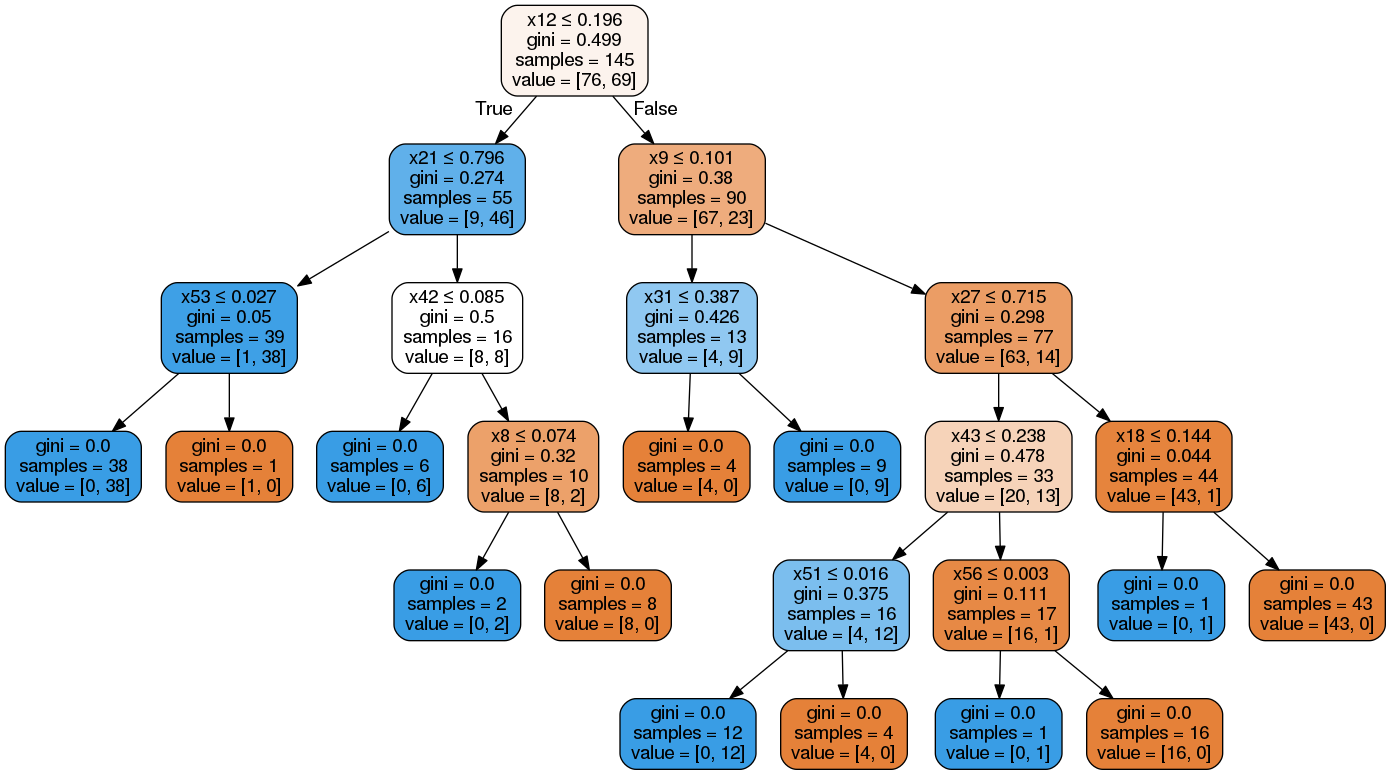

In [10]:
# Visualização da árvore treinada
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = list(df.columns)[:-1])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [11]:
# Com KFold cross validate
dtree = DecisionTreeClassifier(random_state = 76)
cv_results = cross_validate(dtree, X, Y, cv = 10, 
                            scoring = 'accuracy', return_estimator = True, n_jobs = -1)

In [12]:
# Acurácia de treinamento do melhor modelo (média e desvio padrão)
train_score = cv_results['train_score']
print('Acurácia treinamento : ' + str(train_score.mean()) + ' +- ' 
      + str(train_score.std()))

Acurácia treinamento : 1.0 +- 0.0


In [13]:
# Acurácia de teste do melhor modelo (média e desvio padrão)
test_score = cv_results['test_score']
print('Acurácia teste : ' + str(test_score.mean()) + ' +- ' 
      + str(test_score.std()))

Acurácia teste : 0.62508658008658 +- 0.10612134712658473


In [14]:
# Selecionando a melhor árvore obtida no cross validation
best_tree = cv_results['estimator'][np.argmax(cv_results['test_score'])]

In [15]:
best_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=76,
            splitter='best')

### MLP

In [16]:
# Parâmetros cujas combinações serão testadas
mlp_param = {
    'hidden_layer_sizes': [(10,20), (10,20,10), (10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.01, 0.05],
    'learning_rate': ['constant'],
}

In [17]:
# Testa todas as combinações de parâmetros do MLP com KFold
clf_gs_mlp = GridSearchCV(MLPClassifier(), mlp_param, cv=10, n_jobs=-1).fit(X, Y)

In [18]:
# Pega index do melhor modelo
idx=clf_gs_mlp.best_index_

In [19]:
# Acurácia de treinamento do melhor modelo (média e desvio padrão)
train_score_mean = clf_gs_mlp.cv_results_['mean_train_score'][idx]
train_score_std = clf_gs_mlp.cv_results_['std_train_score'][idx]
print('Acurácia treinamento : ' + str(train_score_mean) + ' +- ' 
      + str(train_score_std))

Acurácia treinamento : 0.7911386667351785 +- 0.03813918831659554


In [20]:
# Acurácia de teste do melhor modelo (média e desvio padrão)
test_score_mean = clf_gs_mlp.cv_results_['mean_test_score'][idx]
test_score_std = clf_gs_mlp.cv_results_['std_test_score'][idx]
print('Acurácia teste : ' + str(test_score_mean) + ' +- ' 
      + str(test_score_std))

Acurácia teste : 0.6778846153846154 +- 0.19444393937803617


### RF

In [21]:
# Parâmetros cujas combinações serão testadas
rf_param = {
    'n_estimators': [5, 10, 15, 30], 
    'max_depth': [3, 5, 10], 
    'min_samples_split': [2, 3],
}

In [22]:
# Testa todas as combinações de parâmetros do RF com KFold
clf_gs_rf = GridSearchCV(RandomForestClassifier(n_jobs = -1), rf_param, cv=10, n_jobs=-1).fit(X, Y)

In [23]:
# Pega index do melhor modelo
idx=clf_gs_rf.best_index_

In [24]:
# Acurácia de treinamento do melhor modelo (média e desvio padrão)
train_score_mean = clf_gs_rf.cv_results_['mean_train_score'][idx]
train_score_std = clf_gs_rf.cv_results_['std_train_score'][idx]
print('Acurácia treinamento : ' + str(train_score_mean) + ' +- ' 
      + str(train_score_std))

Acurácia treinamento : 0.9599497539079275 +- 0.021321835953495738


In [25]:
# Acurácia de teste do melhor modelo (média e desvio padrão)
test_score_mean = clf_gs_rf.cv_results_['mean_test_score'][idx]
test_score_std = clf_gs_rf.cv_results_['std_test_score'][idx]
print('Acurácia teste : ' + str(test_score_mean) + ' +- ' 
      + str(test_score_std))

Acurácia teste : 0.7307692307692307 +- 0.13574610744555834
